In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [3]:
h5 = 'cerberus_annot.h5'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1

In [4]:
ca = cerberus.read(h5)
sg = swan.read('swan/swan.p')

Read in graph from swan/swan.p


Triplets for each source in cerberus annotation

In [5]:
df = ca.get_source_triplets(sg=sg)
ca.add_triplets(df)

Expressed triplets

In [6]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1)
df = ca.get_subset_triplets(tids, 'obs_det', sg=sg)
ca.add_triplets(df)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1478: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1477: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 244103
# isos >= 1 tpm: 222246
Number of isos reported: 222246


Sample-level expressed triplets

In [7]:
# TODO - check if results are the same between 
# utils.py TPM calc and this one

In [8]:
df = ca.get_expressed_triplets(sg, obs_col=obs_col, min_tpm=min_tpm,
                                  source='sample_det')
ca.add_triplets(df)

Union of major (90% set) expressed triplets

In [9]:
subset = pd.read_csv('isos_sample_gene_90.tsv', sep='\t')
tids = subset.tid.unique().tolist()
df = ca.get_subset_triplets(tids, source='obs_major', sg=sg)
ca.add_triplets(df)

Sample-level major (90% set) expressed triplets

In [10]:
subset = pd.read_csv('isos_sample_gene_90.tsv', sep='\t')
df = ca.get_expressed_triplets(sg, obs_col=obs_col,
                                      min_tpm=min_tpm,
                                      source='sample_major',
                                      subset=subset)
ca.add_triplets(df)

Remove non-polyA genes

In [11]:
ca.triplets.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
0,v40,ENSG00000000003,3.0,4.0,5.0,5.0,1.428571,TSPAN6,NaN,NaN
1,v40,ENSG00000000005,2.0,2.0,2.0,2.0,1.000000,TNMD,NaN,NaN
2,v40,ENSG00000000419,7.0,6.0,16.0,16.0,2.461538,DPM1,NaN,NaN
3,v40,ENSG00000000457,3.0,4.0,5.0,5.0,1.428571,SCYL3,NaN,NaN
4,v40,ENSG00000000460,5.0,5.0,9.0,9.0,1.800000,C1orf112,NaN,NaN


In [12]:
df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', subset='polya')

In [13]:
df['gid_stable'] = cerberus.get_stable_gid(df, 'gid')

In [14]:
polya_gids = df.gid_stable.tolist()
print(len(ca.triplets.index))
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(polya_gids)]
print(len(ca.triplets.index))       

1545833
1481401


Write triplets to file

In [15]:
ca.write('cerberus_annot_triplets.h5')

you also need to fix this
# issues w/ tss_first_sd_issue nan issue: 0
# issues w/ tes_last_sa_issue nan issue: 0


## sanity checks

In [3]:
# temp = ca.t_map[['transcript_id', 'tss_first_sd_issue']].copy(deep=True)
# print(temp.groupby('tss_first_sd_issue').count())

# temp = ca.t_map[['transcript_id', 'tes_last_sa_issue']].copy(deep=True)
# print(temp.groupby('tes_last_sa_issue').count())

# null are ok because we feed more ends than intron chains
# for lapa
# source_trip.loc[source_trip.n_iso.isnull()]

# ca.ic.loc[(ca.ic.gene_id =='ENSG00000002079')&(ca.ic.source.str.contains('lapa'))]
# ca.tss.loc[(ca.tss.gene_id =='ENSG00000002079')&(ca.tss.source.str.contains('lapa'))]

# ca.t_map.loc[(ca.t_map.gene_id == 'ENSG00000002079')&(ca.t_map.source.str.contains('lapa'))]

## Plotting

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [3]:
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_major']}

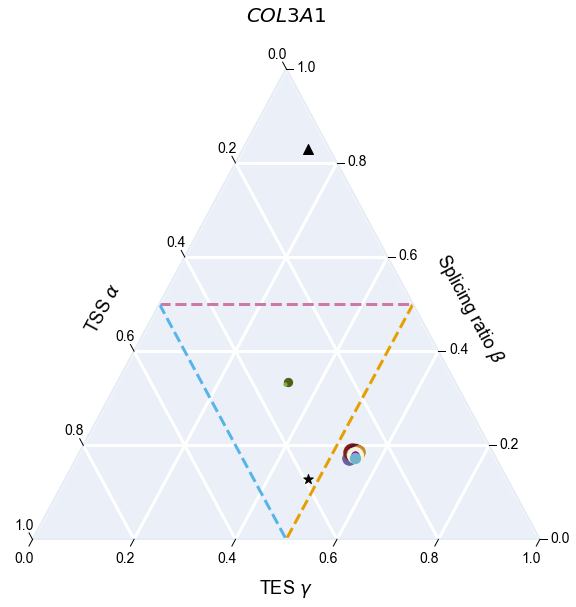

In [4]:
# COL3A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL3A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col3a1_major.pdf')

In [5]:
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_det']}

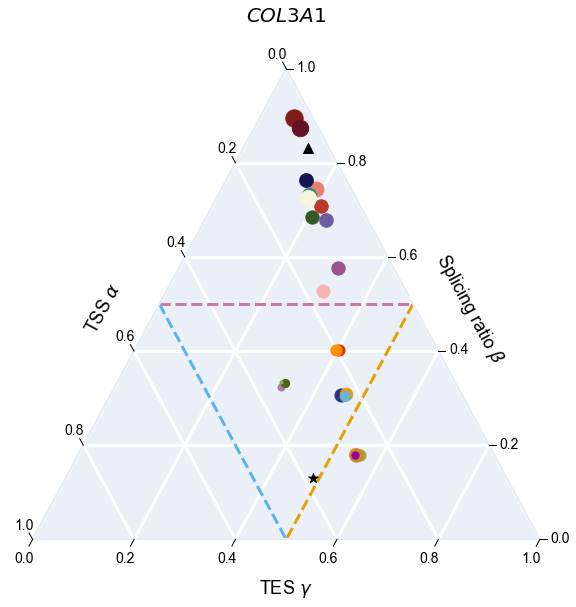

In [6]:
# COL3A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL3A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col3a1.pdf')

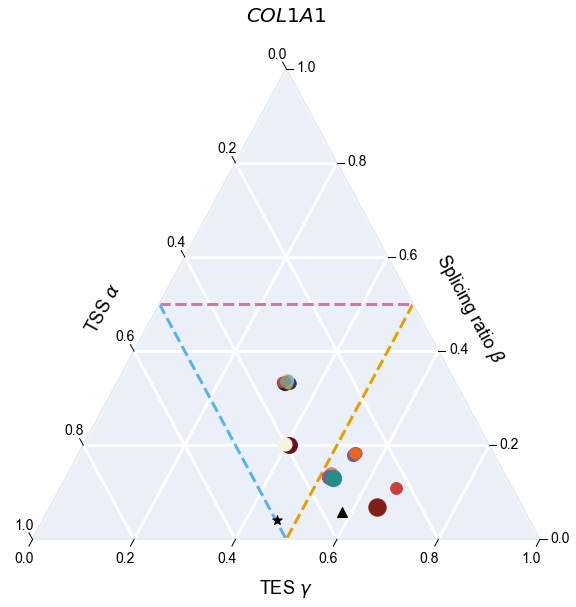

In [7]:
# COL1A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL1A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col1a1.pdf')

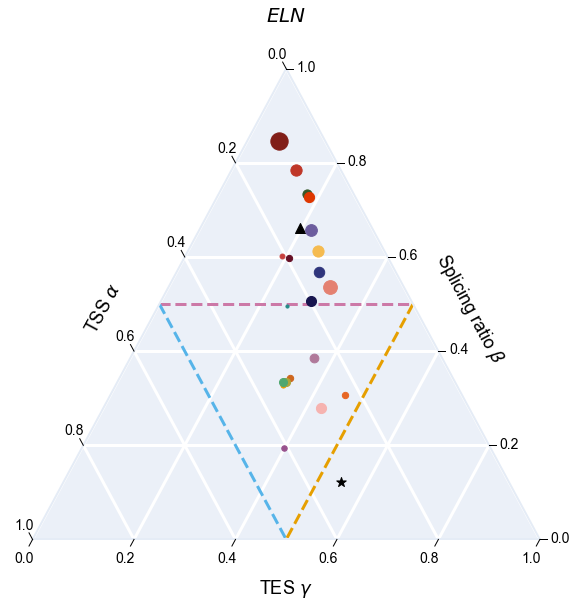

In [8]:
# ELN
df = ca.plot_simplex(top='splicing_ratio', 
            gene='ELN',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/eln.pdf')

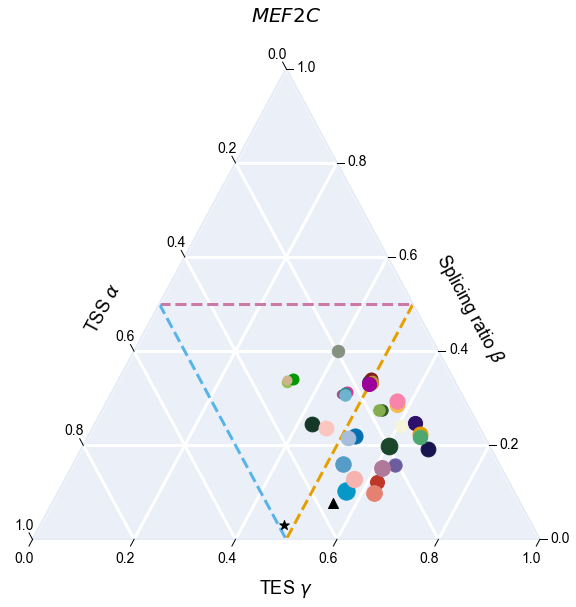

In [9]:
# MEF2C
df = ca.plot_simplex(top='splicing_ratio', 
            gene='MEF2C',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/mef2c.pdf')

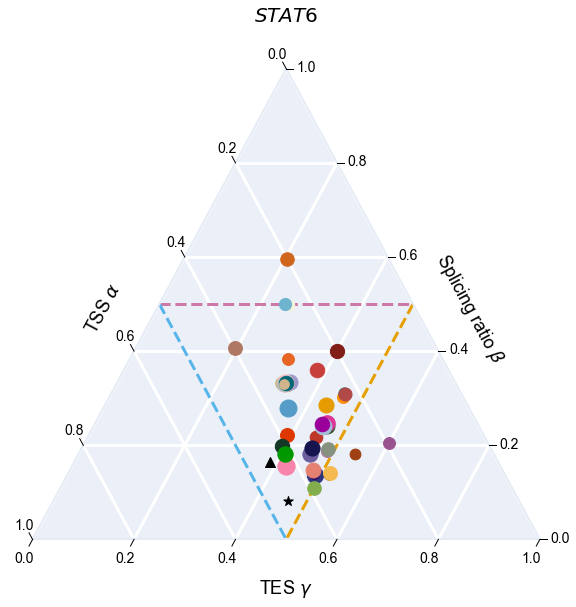

In [10]:
# STAT6
df = ca.plot_simplex(top='splicing_ratio', 
            gene='STAT6',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/stat6.pdf')

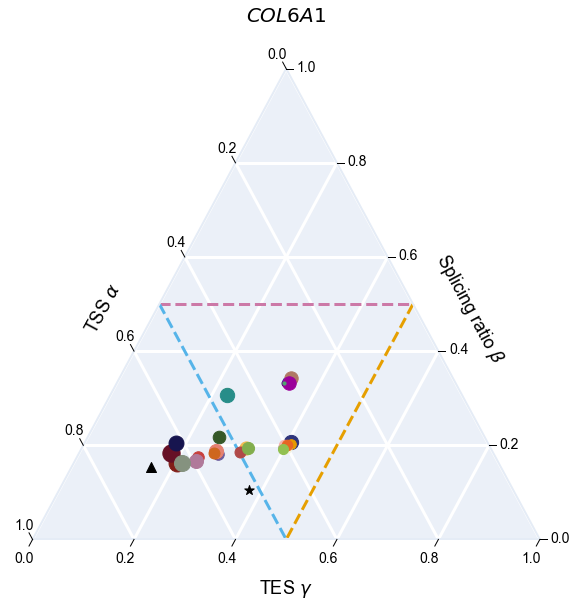

In [11]:
# COL6A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL6A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col6a1.pdf')

In [12]:
def get_sector_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    simple = '#e5ecf6'
    c_dict = {'tss': tss,
              'splicing': splicing,
              'tes': tes,
              'simple': simple, 
              'mixed': '#b7b7b7'}
    order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
    
    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

def plot_sector_gene_counts(counts):
    temp = pd.DataFrame()
    for source in counts.source.unique():
        df = assign_gisx_sector(counts)
        df = df.loc[df.source == source]
        df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
        df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
        df['total_genes'] = df.n_genes.sum()
        temp = pd.concat([temp, df])
    temp['perc'] = (temp.n_genes/temp.total_genes)*100
    # temp = temp.loc[temp.sector != 'simple'] 
    
    y = '% of total genes'
    temp.rename({'perc': y}, axis=1, inplace=True)
    c_dict, order = get_sector_colors(['tss', 'splicing', 'tes', 'mixed', 'simple'])
    # plot both together
    sns.set_context('paper', font_scale=1.8)
    ax = sns.catplot(data=temp, x='source',
                y=y, hue='sector', kind='bar',
                palette=c_dict, saturation=1,
                hue_order=order)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
    #         x = p.get_x() + p.get_width() / 2 - 0.45
            x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.00625
            ax.annotate(percentage, (x, y), size = 12)

    a = ax.axes[0,0]
    add_perc_2(a)
    
    return temp   

In [13]:
ca.triplets.source.unique()

array(['v40', 'lapa', 'v29', 'all', 'obs_det', 'sample_det', 'obs_major',
       'sample_major'], dtype=object)

NameError: name 'vmax' is not defined

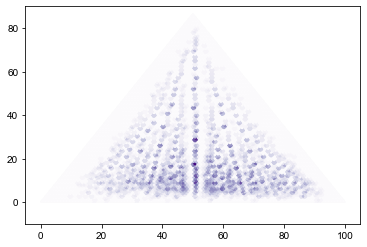

In [14]:
subset = {'source': 'obs_major'}
temp = ca.plot_simplex(top='splicing_ratio',
            subset=subset,
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed major isoforms',
            opref='figures/obs_major_density.pdf')


In [102]:
temp = assign_gisx_sector(temp)
beep = temp

,source,sector,n_genes,total_genes,% of total genes
0,lapa_det_major,mixed,9258,34673,26.700891
1,lapa_det_major,simple,15856,34673,45.730107
2,lapa_det_major,splicing,1037,34673,2.990800
3,lapa_det_major,tes,5356,34673,15.447178
4,lapa_det_major,tss,3166,34673,9.131024


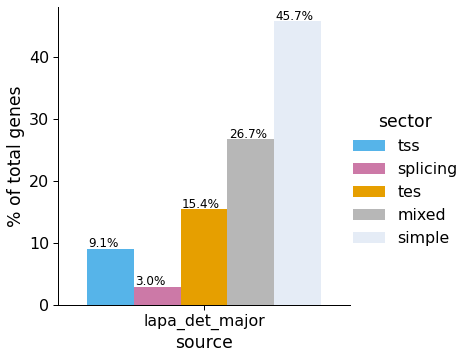

In [103]:
plot_sector_gene_counts(temp)

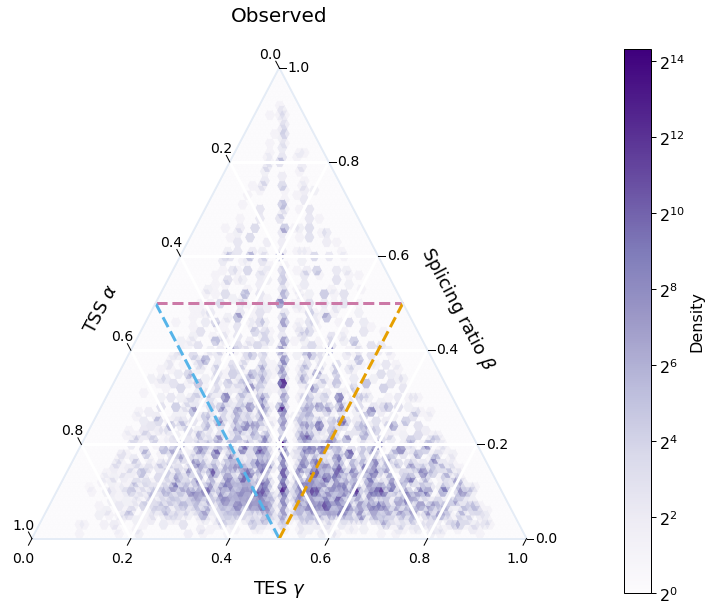

In [104]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'obs'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed',
            opref='figures/human_obs')


In [105]:
temp = assign_gisx_sector(temp)
beep = pd.concat([temp, beep])
# temp[['gid', 'sector']].groupby('sector').count()

,source,sector,n_genes,total_genes,% of total genes
0,obs,mixed,17753,56414,31.469139
1,obs,simple,19875,56414,35.230617
2,obs,splicing,1810,56414,3.208423
3,obs,tes,11084,56414,19.647605
4,obs,tss,5892,56414,10.444216


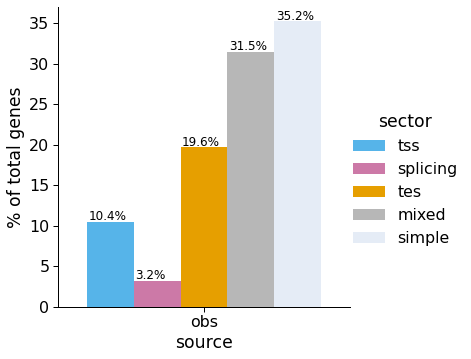

In [106]:
plot_sector_gene_counts(temp)

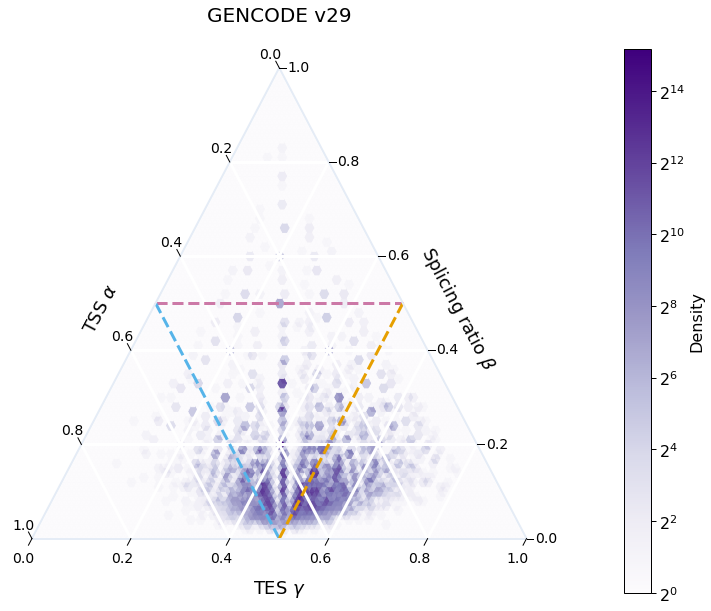

In [107]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'v29'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            title='GENCODE v29',
            opref='figures/human_v29')

In [108]:
temp = assign_gisx_sector(temp)
# temp[['gid', 'sector']].groupby('sector').count()

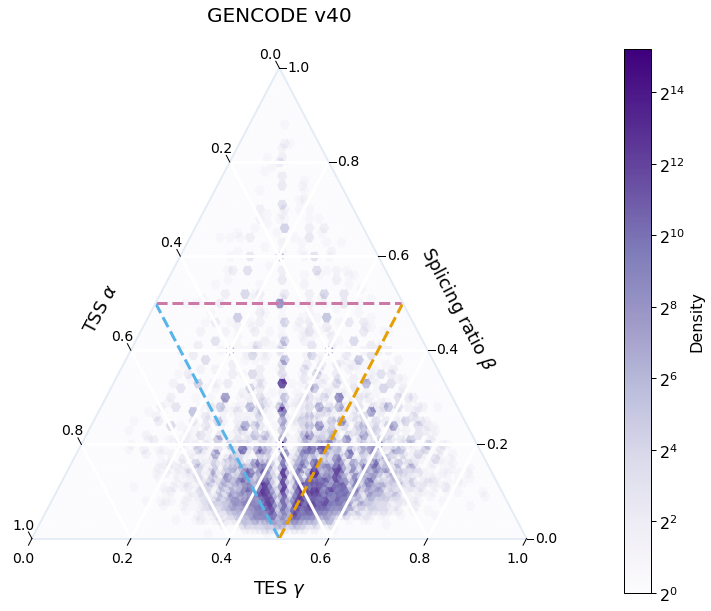

In [109]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'v40'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            title='GENCODE v40',
            opref='figures/human_v40')

In [110]:
# beep = pd.concat([beep, temp])
temp = assign_gisx_sector(temp)
# temp[['gid', 'sector']].groupby('sector').count()
# temp.source.unique()
beep = pd.concat([temp, beep])

,source,sector,n_genes,total_genes,% of total genes
0,v40,mixed,16095,61544,26.152021
1,v40,simple,37436,61544,60.828025
2,v40,splicing,534,61544,0.867672
3,v40,tes,5688,61544,9.242168
4,v40,tss,1791,61544,2.910113


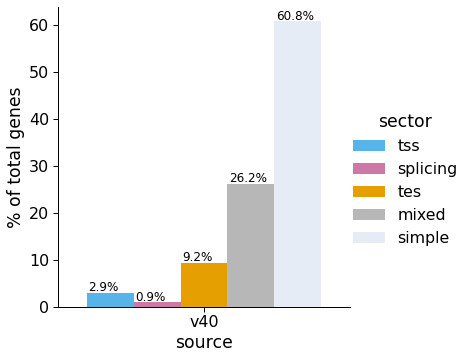

In [111]:
plot_sector_gene_counts(temp)

In [112]:
beep.loc[beep.source == 'lapa_det_major', 'source'] = 'obs_major'
beep.source.unique()

array(['v40', 'obs', 'obs_major'], dtype=object)

In [114]:
counts = beep
temp = pd.DataFrame()
for source in counts.source.unique():
    df = assign_gisx_sector(counts)
    df = df.loc[df.source == source]
    df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
    df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    df['total_genes'] = df.n_genes.sum()
    temp = pd.concat([temp, df])
temp['perc'] = (temp.n_genes/temp.total_genes)*100

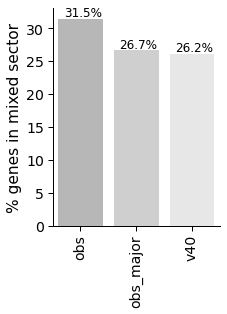

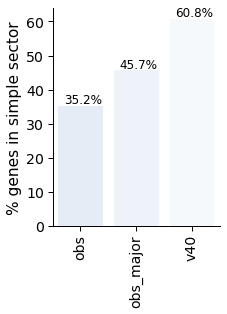

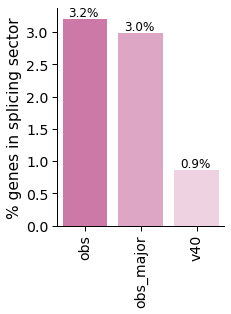

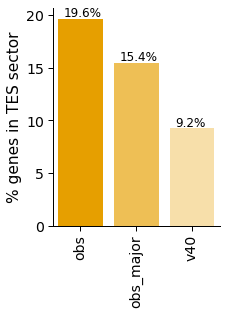

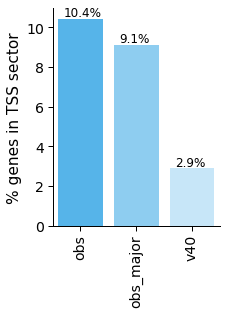

In [116]:
cat1 = 'sector'
cat2 = 'source'
cat2_order = ['obs', 'obs_major', 'v40']
parent_c_dict, parent_order = get_sector_colors()

# loop through first category
for c1 in temp[cat1].unique().tolist():
    beep = temp.loc[temp[cat1] == c1]
    
    c = parent_c_dict[c1]
    c_dict, order = get_shade_colors(c, cat2_order)
    
    # plotting
    sns.set_context('paper', font_scale=1.6)
    plt.figure(figsize=(3,4))

    ax = sns.barplot(data=beep, y='perc', x=cat2,
                     palette=c_dict, order=order,
                     saturation=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    if c1 in ['tss', 'tes']:
        c1 = c1.upper()
    ylabel = '% genes in {} sector'.format(c1)

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.tick_params(axis="x", rotation=90)
    
    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2 - 0.3
            # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size = 12)

    add_perc_2(ax)

In [45]:
# reference + mouse match expressed triplets
e_trip = pd.read_csv('expressed_triplets.tsv', sep='\t')
s_trip = pd.read_csv('mouse_match_triplets.tsv', sep='\t')

# for now, hack together dfs to work with existing code
e_trip.rename({'sample': 'source'}, axis=1, inplace=True)
trips = pd.concat([s_trip, e_trip])
trips.loc[trips.source == 'lapa', 'source'] = 'obs'
trips.loc[trips.source=='all', 'source'] = 'cerberus'

mm_tissues = ['adrenal gland', 'heart', 'muscle', 'brain', 'pgp1_excite_neuron', 'pgp1_astro', 'h9_osteocyte']
mm_annot = ['cerberus', 'v40', 'v29', 'all']
mm_sources = mm_tissues+mm_annot
trips = trips.loc[trips.source.isin(mm_sources)]

In [46]:
trips.source.unique()

array(['heart', 'adrenal gland', 'brain', 'muscle', 'pgp1_astro',
       'h9_osteocyte', 'pgp1_excite_neuron'], dtype=object)

In [47]:
c_dict, order = get_biosample_colors()
c_dict['v29'] = 'k'
c_dict['obs'] = 'k'
c_dict['v40'] = 'k'
c_dict['cerberus'] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs': '^', 'cerberus': '2'}

[array([10.]), array([38.18947019]), array([114.11288002]), array([300.])]


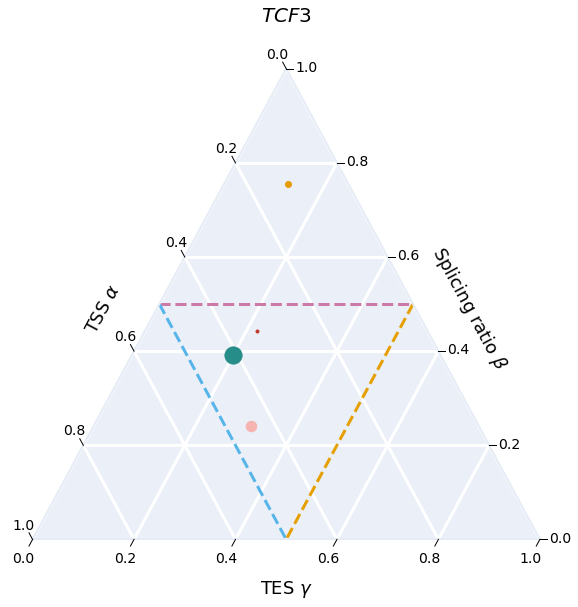

In [48]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([77.14291214]), array([131.02573768])]


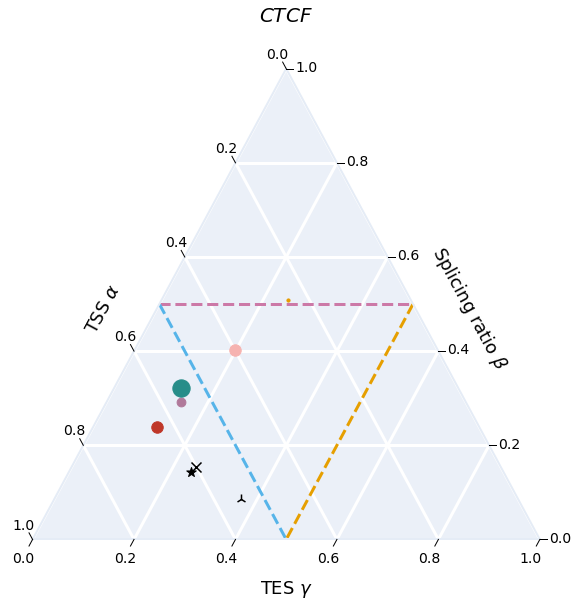

In [60]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([10.]), array([109.86794417])]


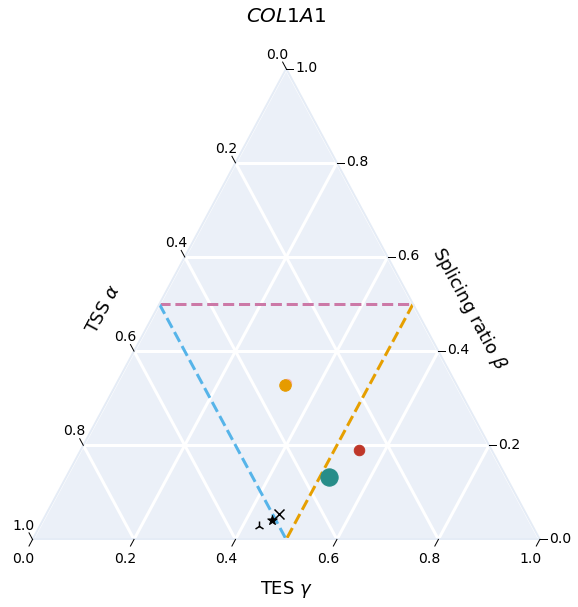

In [35]:
# COL1A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

In [30]:
trips.loc[trips.gname =='COL1A1']

,Unnamed: 0,gid,n_tss,n_tes,n_ic,source,splicing_ratio,gname,n_iso,gene_tpm
39947,39947,ENSG00000108821,12.0,11.0,13.0,v40,1.130435,COL1A1,13.0,NaN
101491,101491,ENSG00000108821,12.0,11.0,13.0,v29,1.130435,COL1A1,13.0,NaN
160695,160695,ENSG00000108821,20.0,16.0,15.0,cerberus,0.833333,COL1A1,0.0,NaN
55689,55689,ENSG00000108821,1.0,1.0,1.0,brain,1.000000,COL1A1,1.0,2.852873
180963,180963,ENSG00000108821,1.0,2.0,1.0,heart,0.666667,COL1A1,2.0,57.795326
471228,471228,ENSG00000108821,1.0,1.0,1.0,muscle,1.000000,COL1A1,1.0,18.003805
483372,483372,ENSG00000108821,1.0,1.0,1.0,adrenal gland,1.000000,COL1A1,1.0,110.667440


In [389]:
trip_df = get_expressed_triplets(c_annot, sg, obs_col='sample', min_tpm=1)

In [390]:
trip_df.head()

,gid,sample,tid,n_tss,n_ic,n_tes,gene_tpm,splicing_ratio,gname
0,ENSG00000000003,hepg2,6,1,3,4,191.014984,1.2,TSPAN6
1,ENSG00000000419,hepg2,6,1,6,2,62.502338,4.0,DPM1
2,ENSG00000000457,hepg2,1,1,1,1,3.207075,1.0,SCYL3
3,ENSG00000000460,hepg2,3,2,3,2,8.606131,1.5,C1orf112
4,ENSG00000001036,hepg2,7,1,5,4,282.548126,2.0,FUCA2


In [206]:
# calculate pi values to get weighted triplet
t_df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col=gb) # this boi is sparse

In [210]:
# add additional stuff to end adatas
sg.tss_adata.var['gene_id'] = sg.tss_adata.var['gid']
sg.tss_adata.var = add_stable_gid(sg.tss_adata.var)
sg.tss_adata.var = sg.tss_adata.var.merge(sg.loc_df[['chrom', 'coord']],
                                          how='left', left_on='vertex_id', 
                                          right_index=True)

In [326]:
def check_gene_sample(sample, gene):
    n_tss = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tss_id'].unique())
    n_ic = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'ic_id'].unique())
    n_tes = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tes_id'].unique())
    n_t = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene)].index.unique())
    
    print('Triplet for {}, {}: [{},{},{}]'.format(sample, gene, n_tss, n_ic, n_tes))
    print('n transcripts: {}'.format(n_t))


In [328]:
# check_gene_sample('hepg2', 'ENSG00000000003')

In [110]:
tss_map = c_annot.tss_map
tss_map = tss_map.loc[~tss_map.Name.isnull()]
tss_map['gene_id'] = tss_map.Name.str.split('_', expand=True)[0]
tss_map.loc[(tss_map.gene_id.isin(t))&(tss_map.source == 'v29')]

,Chromosome,Start,End,Strand,source,Name,gene_id
13224,chr1,11908096,11908197,+,v29,ENSG00000285646_2,ENSG00000285646
13225,chr1,11908101,11908202,+,v29,ENSG00000199347_1,ENSG00000199347
13249,chr1,12166892,12166993,+,v29,ENSG00000283789_1,ENSG00000283789
13510,chr1,16643058,16643159,-,v29,ENSG00000283773_1,ENSG00000283773
14056,chr1,25337414,25337515,-,v29,ENSG00000259984_1,ENSG00000259984
...,...,...,...,...,...,...,...
2484818,chrX,102599461,102599590,+,v29,ENSG00000271147_3,ENSG00000271147
2484821,chrX,147911771,147911872,+,v29,ENSG00000274086_2,ENSG00000274086
2484822,chrX,73944281,73944382,+,v29,ENSG00000274430_2,ENSG00000274430
2484823,chrX,155382064,155382165,+,v29,ENSG00000274791_1,ENSG00000274791


In [104]:
tes.loc[tes.gene_id == 'ENSG00000277577']

,gene_id,n_tes
54299,ENSG00000277577,1


In [88]:
tss.head()

,gene_id,n_tss
0,ENSG00000000003,3
1,ENSG00000000005,2
2,ENSG00000000419,2
3,ENSG00000000457,3
4,ENSG00000000460,5


In [83]:
tss = tss[['Name', 'gene_id']].groupby('gene_id').count().reset_index()
tss.rename({'Name

In [84]:
tss.head()

,Name
gene_id,
ENSG00000000003,3
ENSG00000000005,2
ENSG00000000419,2
ENSG00000000457,3
ENSG00000000460,5


## How many simple-appearing genes do we have? 

In [90]:
# reference + expressed triplets
trips = pd.read_csv('source_triplets.tsv', sep='\t')

In [91]:
trips = trips.loc[trips.source=='lapa_det']

In [92]:
trips.loc[trips.gname == 'KMT2A']

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
222873,ENSG00000118058,10.0,10.0,10.0,lapa_det,12.0,1.0,KMT2A


In [93]:
trips = trips.loc[trips.n_tss == trips.n_tes]
trips = trips.loc[trips.n_ic == trips.n_tes]

In [94]:
trips.head()

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
218239,ENSG00000000005,1.0,1.0,1.0,lapa_det,1.0,1.0,TNMD
218264,ENSG00000002746,1.0,1.0,1.0,lapa_det,1.0,1.0,HECW1
218271,ENSG00000003137,1.0,1.0,1.0,lapa_det,1.0,1.0,CYP26B1
218300,ENSG00000004846,1.0,1.0,1.0,lapa_det,1.0,1.0,ABCB5
218305,ENSG00000004939,1.0,1.0,1.0,lapa_det,1.0,1.0,SLC4A1


In [95]:
len(trips.index)

11999

In [97]:
trips = trips.loc[(trips.n_tss!=1)]
len(trips.index)

717

In [61]:
trips.groupby('n_tss').count()

,gid,n_tes,n_ic,source,n_iso,splicing_ratio,gname
n_tss,,,,,,,
2.0,512,512,512,512,512,512,512
3.0,137,137,137,137,137,137,137
4.0,33,33,33,33,33,33,33
5.0,18,18,18,18,18,18,18
6.0,11,11,11,11,11,11,11
7.0,3,3,3,3,3,3,3
8.0,2,2,2,2,2,2,2
10.0,1,1,1,1,1,1,1


In [66]:
trips.loc[trips.n_tss >= 7]

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
220870,ENSG00000102781,7.0,7.0,7.0,lapa_det,15.0,1.0,KATNAL1
222873,ENSG00000118058,10.0,10.0,10.0,lapa_det,12.0,1.0,KMT2A
223372,ENSG00000122779,7.0,7.0,7.0,lapa_det,28.0,1.0,TRIM24
227135,ENSG00000150764,8.0,8.0,8.0,lapa_det,15.0,1.0,DIXDC1
234081,ENSG00000198081,8.0,8.0,8.0,lapa_det,45.0,1.0,ZBTB14
240464,ENSG00000244405,7.0,7.0,7.0,lapa_det,11.0,1.0,ETV5


In [69]:
gids = trips.loc[trips.n_tss>=7, 'gid'].tolist()
gids

['ENSG00000102781',
 'ENSG00000118058',
 'ENSG00000122779',
 'ENSG00000150764',
 'ENSG00000198081',
 'ENSG00000244405']

In [63]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1478: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1477: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 244103
# isos >= 1 tpm: 222246
Number of isos reported: 222246


In [73]:
tids = []
for gid in gids:
    tids+=df.loc[df.index.str.contains(gid)].index.tolist()

In [75]:
ca.t_map.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source
0,ENST00000003912.7,2,ENSG00000001461_2,ENSG00000001461_1,1,ENSG00000001461_1,1,ENSG00000001461,NIPAL3,NIPAL3-201,"[1,2,1]","ENSG00000001461[1,2,1]","NIPAL3[1,2,1]",False,False,v29
1,ENST00000008440.9,3,ENSG00000010072_3,ENSG00000010072_1,1,ENSG00000010072_2,2,ENSG00000010072,SPRTN,SPRTN-201,"[1,3,2]","ENSG00000010072[1,3,2]","SPRTN[1,3,2]",False,False,v29
2,ENST00000009105.5,2,ENSG00000008118_2,ENSG00000008118_1,1,ENSG00000008118_1,1,ENSG00000008118,CAMK1G,CAMK1G-201,"[1,2,1]","ENSG00000008118[1,2,1]","CAMK1G[1,2,1]",False,False,v29
3,ENST00000010299.10,2,ENSG00000009780_2,ENSG00000009780_1,1,ENSG00000009780_3,3,ENSG00000009780,FAM76A,FAM76A-201,"[1,2,3]","ENSG00000009780[1,2,3]","FAM76A[1,2,3]",False,False,v29
4,ENST00000011700.10,6,ENSG00000048707_6,ENSG00000048707_5,5,ENSG00000048707_13,13,ENSG00000048707,VPS13D,VPS13D-201,"[5,6,13]","ENSG00000048707[5,6,13]","VPS13D[5,6,13]",False,False,v29


In [78]:
temp = ca.t_map.loc[ca.t_map.source=='lapa']
temp = temp.loc[temp.transcript_id.isin(tids)]

In [79]:
temp.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source
47000,ENCODEHT000919949#0,10,ENSG00000150764_10,ENSG00000150764_9,9,ENSG00000150764_9,9,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[9,10,9]","ENSG00000150764[9,10,9]","DIXDC1[9,10,9]",False,False,lapa
47001,ENCODEHT000919949#1,10,ENSG00000150764_10,ENSG00000150764_9,9,ENSG00000150764_2,2,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[9,10,2]","ENSG00000150764[9,10,2]","DIXDC1[9,10,2]",False,False,lapa
47002,ENCODEHT000919949#2,10,ENSG00000150764_10,ENSG00000150764_1,1,ENSG00000150764_2,2,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[1,10,2]","ENSG00000150764[1,10,2]","DIXDC1[1,10,2]",False,False,lapa
47113,ENCODEHT000937211#0,40,ENSG00000118058_40,ENSG00000118058_26,26,ENSG00000118058_29,29,ENSG00000118058,KMT2A,ENCODEHT000937211,"[26,40,29]","ENSG00000118058[26,40,29]","KMT2A[26,40,29]",False,False,lapa
49857,ENST00000392873.4,16,ENSG00000118058_16,ENSG00000118058_6,6,ENSG00000118058_12,12,ENSG00000118058,KMT2A,KMT2A-202,"[6,16,12]","ENSG00000118058[6,16,12]","KMT2A[6,16,12]",False,False,lapa


In [81]:
temp = temp.merge(ca.ic[['Name', 'novelty']].drop_duplicates(), how='left',
                  left_on='ic_id', right_on='Name')

In [86]:
print(len(temp.transcript_id.unique()))
print(len(tids))

126
126


In [88]:
temp = temp[['transcript_id', 'gene_id', 'gene_name', 'novelty']].drop_duplicates()

In [89]:
temp = temp[['transcript_id', 'novelty']]
temp.groupby('novelty').count()

,transcript_id
novelty,
ISM,20
Known,86
NIC,9
NNC,11
